# TKT4108 Structural dynamics 2

## Solution exercise 7

**Main topics:**  Spectral density of dynamic response, extreme response of narrow banded processes

**References:** Newland Chapter 7, 8

### Problem 1: Transmission of random variables 



**a)**

Strategy:

*i)* Create a list of nodes with their corresponding coordinates.

*ii)* Generate lists of elements, where each element connects specific nodes.

*iii)* Define the local $4\times4$ mass and stiffness matrices for each element.

*iv)* For each element, apply rotation transformations to global coordinates, and assemble the full mass and stiffness matrices by mapping element matrices to the corresponding degrees of freedom (DOFs).

*v)* Apply boundary conditions by identifying DOFs that are constrained (e.g., zero displacement). Define a vector of reduced DOFs and calculate the reduced global mass and stiffness matrices.

*vi)* Perform system calculations such as solving for static responses or dynamic analysis (e.g., solving the eigenvalue problem).

*vii)* After solving for the reduced vector of DOFs, reconstruct the full vector of DOFs.


Element number 1: Node indices = 0, 1
Element number 2: Node indices = 1, 2
Element number 3: Node indices = 2, 3
Element number 4: Node indices = 3, 4
Element number 5: Node indices = 4, 5
Element number 6: Node indices = 5, 6
Element number 7: Node indices = 6, 7
Element number 8: Node indices = 8, 9
Element number 9: Node indices = 9, 10
Element number 10: Node indices = 10, 11
Element number 11: Node indices = 11, 12
Element number 12: Node indices = 12, 13
Element number 13: Node indices = 13, 14
Element number 14: Node indices = 0, 8
Element number 15: Node indices = 8, 1
Element number 16: Node indices = 1, 9
Element number 17: Node indices = 9, 2
Element number 18: Node indices = 2, 10
Element number 19: Node indices = 10, 3
Element number 20: Node indices = 3, 11
Element number 21: Node indices = 11, 4
Element number 22: Node indices = 4, 12
Element number 23: Node indices = 12, 5
Element number 24: Node indices = 5, 13
Element number 25: Node indices = 13, 6
Element number 26

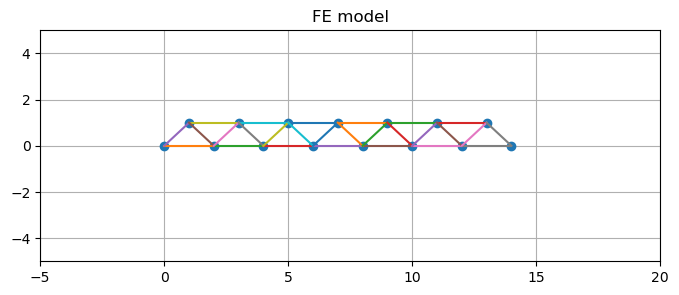

In [1]:
import numpy as np
from scipy import linalg as spla
from matplotlib import pyplot as plt

import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration


# Define bar element
def bar_element(E,A,rho,x1,x2):
    
    L = ((x2-x1) @ (x2-x1))**0.5 # Calculate element length

    # Local matrices
    k_local = E*A/L*np.array([[1, 0, -1, 0],[0, 0, 0, 0],[-1, 0, 1, 0],[0, 0, 0, 0]])
    m_local = rho*A*L/6*np.array([[2, 0, 1, 0],[0, 2, 0, 1],[1, 0, 2, 0],[0, 1, 0, 2]])


    # Find rotation transformation matrix T
    # Will produce same result as a cos(theta) and sin(theta) approach
    
    e1 = (x2-x1)/L # Vector along element
    e2 = np.cross(np.array([0, 0, 1]),np.append(e1,0)) # Find vector 90 deg to e1 by cross-product
    e2 = e2[0:-1]

    T_glob2loc = np.vstack((e1,e2))
    T_glob2loc_element = spla.block_diag(T_glob2loc,T_glob2loc)

    # Element matrices in global coordinate system
    
    k_global = T_glob2loc_element.T @ k_local @ T_glob2loc_element
    m_global = T_glob2loc_element.T @ m_local @ T_glob2loc_element
    
    return L, k_global, m_global


# Define nodes and elements (node number,x,y)
nodes = np.array([[1, 0, 0],
[2, 2, 0],
[3, 4, 0],
[4, 6, 0],
[5, 8, 0],
[6, 10, 0],
[7, 12, 0],
[8, 14, 0],
[9, 1, 1],
[10, 3, 1],
[11, 5, 1],
[12, 7, 1],
[13, 9, 1],
[14, 11, 1],
[15, 13, 1]],dtype=float)

# Define elements (element number, start node, end node, element type)
elements = np.array([[1, 1, 2, 1],
[2, 2, 3, 1],
[3, 3, 4, 1],
[4, 4, 5, 1],
[5, 5, 6, 1],
[6, 6, 7, 1],
[7, 7, 8, 1],
[8, 9, 10, 1],
[9, 10, 11, 1],
[10, 11, 12, 1],
[11, 12, 13, 1],
[12, 13, 14, 1],
[13, 14, 15, 1],
[14, 1, 9, 1],
[15, 9, 2, 1],
[16, 2, 10, 1],
[17, 10, 3, 1],
[18, 3, 11, 1],
[19, 11, 4, 1],
[20, 4, 12, 1],
[21, 12, 5, 1],
[22, 5, 13, 1],
[23, 13, 6, 1],
[24, 6, 14, 1],
[25, 14, 7, 1],
[26, 7, 15, 1],
[27, 15, 8, 1]])

# Plot nodes and elements
plt.figure(figsize=(8,3))
plt.plot(nodes[:,1],nodes[:,2],'o') # Plot nodes as dots
plt.title('FE model')

# Plot elements as lines
for k in range(elements.shape[0]):
    
    # Find indices of the nodes that define the current element
    node_idx1 = np.where(nodes[:, 0] == elements[k, 1])[0][0]  # Index of node 1
    node_idx2 = np.where(nodes[:, 0] == elements[k, 2])[0][0]  # Index of node 2
    
    print(f'Element number {elements[k,0]}: Node indices = {node_idx1}, {node_idx2}')

    x1 = nodes[node_idx1, 1:]  # Coordinates of node 1 
    x2 = nodes[node_idx2, 1:]  # Coordinates of node 2

    # Plot one element
    plt.plot([x1[0],x2[0]],[x1[1],x2[1]])
    
plt.xlim(-5,20)
plt.ylim(-5,5)
plt.grid()


The model geometry with nodes and elements seem correct. 

We continue to assemble system matrices and calculate modes.

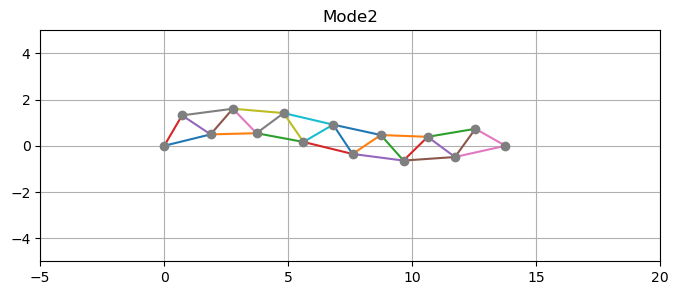

In [2]:

# Assembly bar element model
E = 1.0e10
A = 0.2*0.2
rho = 2000
mass_matrix = np.zeros((nodes.shape[0]*2,nodes.shape[0]*2))
stiffness_matrix = np.zeros((nodes.shape[0]*2,nodes.shape[0]*2)) 

# Loop over all elements
for k in range(elements.shape[0]):
    
    # Find indices of the nodes that define the current element
    node_idx1 = np.where(nodes[:, 0] == elements[k, 1])[0][0]  # Index of node 1
    node_idx2 = np.where(nodes[:, 0] == elements[k, 2])[0][0]  # Index of node 2
    
    # Get the coordinates of the two nodes
    x1 = nodes[node_idx1, 1:]  # Coordinates of node 1 
    x2 = nodes[node_idx2, 1:]  # Coordinates of node 2
    
    # Local element matrices
    L, k_global, m_global = bar_element(E,A,rho,x1,x2) 

    # Assign to full matrices
    stiffness_matrix[2*node_idx1:2*(node_idx1+1),2*node_idx1:2*(node_idx1+1)] += k_global[0:2,0:2]
    stiffness_matrix[2*node_idx1:2*(node_idx1+1),2*node_idx2:2*(node_idx2+1)] += k_global[0:2,2:] 
    stiffness_matrix[2*node_idx2:2*(node_idx2+1),2*node_idx1:2*(node_idx1+1)] += k_global[2:,0:2] 
    stiffness_matrix[2*node_idx2:2*(node_idx2+1),2*node_idx2:2*(node_idx2+1)] += k_global[2:,2:] 
    
    mass_matrix[2*node_idx1:2*(node_idx1+1),2*node_idx1:2*(node_idx1+1)] += m_global[0:2,0:2]
    mass_matrix[2*node_idx1:2*(node_idx1+1),2*node_idx2:2*(node_idx2+1)] += m_global[0:2,2:] 
    mass_matrix[2*node_idx2:2*(node_idx2+1),2*node_idx1:2*(node_idx1+1)] += m_global[2:,0:2] 
    mass_matrix[2*node_idx2:2*(node_idx2+1),2*node_idx2:2*(node_idx2+1)] += m_global[2:,2:] 
 
   
# Boundary conditions
T_bc = np.eye(nodes.shape[0]*2)
T_bc = np.delete(T_bc,[0, 1 , 2*7+1],axis=1) # Delete two DOFs left support and 1 DOF at right support

stiffness_matrix_bc = T_bc.T @ stiffness_matrix @ T_bc
mass_matrix_bc = T_bc.T @ mass_matrix @ T_bc

# natural frequencies and modes
lam,vec = spla.eig(stiffness_matrix_bc,mass_matrix_bc)
idx_sort = np.argsort(np.abs(lam)) # Sorting order (small to big)

lam = lam[idx_sort]
vec = vec[:,idx_sort] # Modes
f = np.real(lam**0.5)/2/np.pi # Natural frequencies

#print(f)

# Plot modes
scale = 2.0

# Mode plot
mode_plot=2 # Select mode number to be plotted

u = T_bc @ vec[:,mode_plot-1] # Transform to vector of full DOFs

# Take original nodes, add a displacement according to the mode shape
nodes_deformed = np.copy(nodes)
nodes_deformed[:,1] = nodes_deformed[:,1]+scale*u[0::2]
nodes_deformed[:,2] = nodes_deformed[:,2]+scale*u[1::2]

plt.figure(figsize=(8,3))
for k in range(elements.shape[0]):

    # Find indices of the nodes that define the current element
    node_idx1 = np.where(nodes[:, 0] == elements[k, 1])[0][0]  # Index of node 1
    node_idx2 = np.where(nodes[:, 0] == elements[k, 2])[0][0]  # Index of node 2
    
    x1 = nodes_deformed[node_idx1, 1:]  # Coordinates of node 1 
    x2 = nodes_deformed[node_idx2, 1:]  # Coordinates of node 2

    # Plot one element
    plt.plot([x1[0],x2[0]],[x1[1],x2[1]])

plt.plot(nodes_deformed[:,1],nodes_deformed[:,2],'o')
plt.title('Mode' + str(mode_plot))
plt.xlim(-5,20)
plt.ylim(-5,5)
plt.grid()

For modes 4 and higher, we should probably use a finer mesh. However, mode 1 and 2 looks very well represented.

**b)**


$$ \mathbf{C} = \alpha_1 \mathbf{M} + \alpha_2 \mathbf{K} $$

The factors $\alpha_1$ and $\alpha_2$ depend on the natural frequencies and the damping ratio of the two modes that are selected.

$$ \alpha_{1} = 2 \omega_{1}\omega_2 \frac{\left(\xi_2\omega_{1}-\xi_{1}\omega_2 \right)} {\omega_{1}^2-\omega_2^2} $$

$$ \alpha_2 = 2 \frac{\xi_1 \omega_1 -\xi_2\omega_2}{\omega_1^2-\omega_2^2}    $$


In [ ]:
xi = np.array(([0.5, 0.5]))/100
omega = f*2*np.pi
alpha1 = 2*omega[0]*omega[1]*(xi[1]*omega[0]-xi[0]*omega[1])/(omega[0]**2-omega[1]**2)
alpha2 = 2*(xi[0]*omega[0]-xi[1]*omega[1])/(omega[0]**2-omega[1]**2)
damping_matrix_bc = alpha1*mass_matrix_bc + alpha2*stiffness_matrix_bc

**c)**

We generate loads from the spectrum in the usual manner. To ensure the loads are not fully correlated, the generation process must be repeated with different phase angles each time. This prevents the two loads from being identical.


In [ ]:

T=60
dt=0.001

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
print('domega is ' + str(domega))

omega = np.arange(0,N,1)*domega # Frequency axis

alpha0 = 10.0
omega0 =  5*2*np.pi
Sx = 10000/np.pi*alpha0/(alpha0**2+(omega-omega0)**2)

# Generate x1
phi = np.random.rand(N)*2*np.pi # Random phase angles 
c = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x1 = np.real(np.fft.ifft(c)*N) # The IFFT

# Generate x2
phi = np.random.rand(N)*2*np.pi # Random phase angles 
c = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x2 = np.real(np.fft.ifft(c)*N) # The IFFT

plt.figure(figsize=(8,3))
plt.plot(t,x1,label='x1')
plt.plot(t,x2,label='x2')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.title('Realization of loads')
plt.grid()
plt.legend()
plt.xlim(0,T)


**d)**

We have to introduce the loads in the correct degrees of freedom. The drawing of the truss shows that the loads are introduced in the vertical degree of freedom in nodes three and five. This corresponds to degrees of freedom 6 and 10. Please also notice that some degrees of freedom have been removed since we introduced boundary conditions. Assigning $x_1$ and $x_2$ to the correct index in the load vector is important.


In [ ]:
load = np.zeros((nodes.shape[0]*2,len(t))) # Full load vector
load[5,:] = x1 # Load in degree of freedom 6
load[9,:] = x2 # Load in degree of freedom 10

load_bc = T_bc.T @ load # Reduced load vector

y0 = np.zeros((load_bc.shape[0],1))
ydot0 = np.zeros((load_bc.shape[0],1))

y_bc,_,_ = linear_newmark_krenk(mass_matrix_bc,damping_matrix_bc,stiffness_matrix_bc,load_bc,y0,ydot0,dt)

y = T_bc @ y_bc

# Plot the response in a selected node
selected_node = 5
plt.figure(figsize=(8,3))
plt.plot(t,y[2*(selected_node-1)+0,:]*1000,label='Horizontal')
plt.plot(t,y[2*(selected_node-1)+1,:]*1000,label='Vertical',alpha=0.5)
plt.xlim(0,T)
plt.legend()
plt.grid()
plt.xlabel('$t$')
plt.ylabel('$y(t) (mm)$')
plt.title('Response in node ' + str(selected_node))



The easiest way to calculate the forces in elements 20 and 21 is to consider each element's stiffness matrix in the element's local coordinate system and multiply this with the displacements of the element nodes in local coordinates.

<center>
<img src='bar_rotated.svg' width=100%>
</center>

$$\mathbf{F}_{local} = \mathbf{k}_{local} \mathbf{y}_{local} $$

In other words, we need to obtain the stiffness matrix of the two elements in their local coordinate systems. We need to pick the calculated displacements in the nodes of these elements and transform these into the local coordinate system of each element. This is straightforward, but one needs to pay close attention to avoid picking the wrong displacements.



In [ ]:
# Element 20
x1 = nodes[3,1::]
x2 = nodes[11,1::]
L_20 = ((x2-x1) @ (x2-x1))**0.5
e1 = (x2-x1)/L_20    
e2 = np.cross(np.array([0, 0, 1]),np.append(e1,0))
e2 = e2[0:-1]
T_glob2loc = np.vstack((e1,e2))
T_glob2loc_element_20 = spla.block_diag(T_glob2loc,T_glob2loc)
k_local_20 = E*A/L_20*np.array([[1, 0, -1, 0],[0, 0, 0, 0],[-1, 0, 1, 0],[0, 0, 0, 0]])
selected_node = 4
y_4 = y[2*(selected_node-1):2*(selected_node-1)+2]
selected_node = 12
y_12 = y[2*(selected_node-1):2*(selected_node-1)+2]
y_element_20 = np.vstack((y_4,y_12))
y_local_element_20 = T_glob2loc_element_20 @ y_element_20

F_20 = k_local_20 @ y_local_element_20


#Element 21
x1 = nodes[11,1::]
x2 = nodes[4,1::]
L_21 = ((x2-x1) @ (x2-x1))**0.5
e1 = (x2-x1)/L_21    
e2 = np.cross(np.array([0, 0, 1]),np.append(e1,0))
e2 = e2[0:-1]
T_glob2loc = np.vstack((e1,e2))
T_glob2loc_element_21 = spla.block_diag(T_glob2loc,T_glob2loc)
k_local_21 = E*A/L_21*np.array([[1, 0, -1, 0],[0, 0, 0, 0],[-1, 0, 1, 0],[0, 0, 0, 0]])
selected_node = 12
y_12 = y[2*(selected_node-1):2*(selected_node-1)+2]
selected_node = 5
y_5 = y[2*(selected_node-1):2*(selected_node-1)+2]
y_element_21 = np.vstack((y_12,y_5))
y_local_element_21 = T_glob2loc_element_21 @ y_element_21

F_21 = k_local_21 @ y_local_element_21


print('Standard deviation for element 20 is ' + '{:.3e}'.format(np.std(F_20)) )
print('Standard deviation for element 21 is ' + '{:.3e}'.format(np.std(F_21)) )

plt.figure(figsize=(8,3))
plt.plot(t,F_20[0,:],label='Element 20')
plt.plot(t,F_21[0,:],label='Element 21')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Axial force (N)')
plt.title('Element force')
plt.xlim(0,T)

plt.figure(figsize=(8,3))
plt.plot(F_20[0,:],F_21[0,:],'o')
plt.grid()
plt.xlabel('$N_{20}$')
plt.ylabel('$N_{21}$')
plt.title('Correlation coefficient = ' + str(np.corrcoef(np.vstack((F_20[0,:],F_21[0,:])))[0,1]));


The results above show that the standard deviation of the axial force in element 21 is slightly higher than the axial force in element 20. This is partly explained by the fact that the second action is acting more directly on element 21. It is also observed that the correlation of the axial forces in the two members is weak. This is because the truss is excited in several modes. It should also be noted that the correlation will always be perfect if it is only one mode that contributes to the response. In this case, the contribution from higher modes reduces the correlation.

**e)**

The following relation can obtain the internal forces in the elements

$$ \mathbf{F}(t) = \left[ \begin{array}{c}  \mathbf{k}_{20,local} \mathbf{T}_{G2L,20} & \mathbf{0} \\ \mathbf{0} & \mathbf{k}_{21,local} \mathbf{T}_{G2L,21}   \end{array} \right] \mathbf{y}_{4,12,5}(t) $$

$$ \mathbf{F}(t) =  \mathbf{T}_{y2F}  \mathbf{y}_{4,12,5}(t) $$

This is the same as the calculations performed in the solution of the previous problem but in matrix notation, which is more convenient when obtaining the expression for the cross-spectral density matrix of the internal forces in the members.

The cross-correlation matrix is obtained by

$$\mathbf{R_F}(\tau) = E \left[\mathbf{F}(t) \mathbf{F}^\text{T}(t+\tau)  \right]  $$

$$\mathbf{R_F}(\tau) = E \left[\mathbf{T}_{y2F}  \mathbf{y}_{4,12,5}(t)   \mathbf{y}^\text{T}_{4,12,5}(t+\tau) \mathbf{T}^\text{T}_{y2F}  \right]  $$

$$\mathbf{R_F}(\tau) = \mathbf{T}_{y2F} E \left[  \mathbf{y}_{4,12,5}(t)   \mathbf{y}^\text{T}_{4,12,5}(t+\tau)  \right] \mathbf{T}^\text{T}_{y2F}  $$

$$\mathbf{R_F}(\tau) = \mathbf{T}_{y2F}  \mathbf{R_y}_{4,12,5}(\tau)   \mathbf{T}^\text{T}_{y2F}  $$

The cross-spectral density matrix is obtained by taking the Fourier transform of the cross-correlation matrix.

$$\mathbf{S_F}(\omega) = \mathbf{T}_{y2F}  \mathbf{S_y}_{4,12,5}(\omega)   \mathbf{T}^\text{T}_{y2F}  $$


In [ ]:
omega = np.arange(0,10000,1)*0.1 # Frequency axis

# Frequency response matrix
H = np.zeros((stiffness_matrix_bc.shape[0],stiffness_matrix_bc.shape[1],len(omega)),dtype=complex)
for k in range(len(omega)):    
    H[:,:,k] = np.linalg.inv(-omega[k]**2*mass_matrix_bc + 1j*omega[k]*damping_matrix_bc + stiffness_matrix_bc)
    
k1=8
k2 = 8
plt.figure(figsize=(8,3))
plt.plot(omega,np.abs(H[k1,k2,:]),label = 'Abs')
plt.grid()

plt.xlabel('$\omega$')
plt.ylabel('$H_{' + str(k1) + str(k2) + '}$')
plt.title('One of the elements in the frequency-response matrix');
plt.xlim(0,500)
#plt.yscale('log')


In [ ]:
# Cross spectral densities of the loads
Sx = np.zeros((stiffness_matrix.shape[0],stiffness_matrix.shape[1],len(omega)))

Sx0 = 10000/np.pi*alpha0/(alpha0**2+(omega-omega0)**2)

selected_node = 3
Sx[2*(selected_node-1)+1,2*(selected_node-1)+1,:] = Sx0

selected_node = 5
Sx[2*(selected_node-1)+1,2*(selected_node-1)+1,:] = Sx0

# Remove constrained degrees of freedom

Sx_bc = np.zeros((stiffness_matrix_bc.shape[0],stiffness_matrix_bc.shape[1],len(omega)))

for k in range(len(omega)):
    Sx_bc[:,:,k] = T_bc.T @ Sx[:,:,k] @ T_bc
               

In [ ]:
# Cross-spectral density of the response

Sy_bc = np.zeros((H.shape),dtype='complex')
for k in range(len(omega)):
    Sy_bc[:,:,k] = H[:,:,k] @ Sx_bc[:,:,k] @  np.conj(H[:,:,k]).T

# Plot for one DOF to check
selected_node = 5
plt.figure(figsize=(8,3))
plt.plot(omega,np.real(Sy_bc[2*(selected_node-1)+1,2*(selected_node-1)+1,:]),label = 'Re')
#plt.plot(omega,np.imag(Sy_bc[2*(selected_node-1)+1,2*(selected_node-1)+1,:]),label = 'Im')
plt.grid()

plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.title('Auto-spectral density of vertical response in node ' + str(selected_node));

plt.yscale('log')

In [ ]:
# Cross-spectral density of the response (full vector)

Sy = np.zeros((stiffness_matrix.shape[0], stiffness_matrix.shape[1],len(omega)),dtype='complex')
for k in range(len(omega)):
    Sy[:,:,k] = T_bc @ Sy_bc[:,:,k] @ T_bc.T

# Cross-spectral density of the internal forces

selected_dofs = np.array([2*(4-1),2*(4-1)+1,2*(12-1),2*(12-1)+1,2*(5-1),2*(5-1)+1])

Ty2F = np.zeros((8,6))
Ty2F[0:4,0:4] = k_local_20 @ T_glob2loc_element_20
Ty2F[4::,2::] = k_local_21 @ T_glob2loc_element_21

S_F = np.zeros((8,8,len(omega)),dtype=complex)

for k in range(len(omega)):

    Sy_tmp=Sy[:,:,k] # Select temporarily only this frequency
    
    S_F[:,:,k] = Ty2F @ Sy_tmp[selected_dofs,:][:,selected_dofs] @ Ty2F.T # Select rows and columns of selected DOFs
    
plt.figure(figsize=(8,3))
plt.plot(omega,np.real(S_F[0,0,:]))
plt.plot(omega,np.imag(S_F[0,0,:]))
plt.xlabel('$\omega$')
plt.ylabel('$S_{N20}$')
plt.grid()
plt.title('$\sigma = $' + str(np.real(np.trapz(S_F[0,0],omega)**0.5)))

plt.figure(figsize=(8,3))
plt.plot(omega,np.real(S_F[4,4,:]))
plt.plot(omega,np.imag(S_F[4,4,:]))
plt.xlabel('$\omega$')
plt.ylabel('$S_{N21}$')
plt.grid()
plt.title('$\sigma = $' + str(np.real(np.trapz(S_F[4,4],omega)**0.5)))

plt.figure(figsize=(8,3))
plt.plot(omega,np.real(S_F[0,4,:]))
plt.plot(omega,np.imag(S_F[0,4,:]))
plt.xlabel('$\omega$')
plt.ylabel('$S_{N20,N21}$')
plt.grid()
plt.title(r'$\rho = $' + str(np.real(np.trapz(S_F[0,4],omega)/np.trapz(S_F[0,0],omega)**0.5/np.trapz(S_F[4,4],omega)**0.5)));

The three figures show the auto-spectral density of the axial force in the two members and their cross-spectral density. The standard deviation and covariance coefficient are also given. It is observed that the time domain results are not perfectly equal to the time domain results. This is because the time domain results are only estimates of the statistical properties of the response process, and the average of many realizations needs to be considered to obtain accurate results. If we calculate the response ten times in the time domain, the average statistical properties correspond very well to the frequency domain results. It is also interesting to observe that the first mode contributes to positive covariance, while the second mode contributes to reducing the covariance of the forces in the two members. This is what typically happens in systems with several degrees of freedom.


### Problem 2: Response statistics

**a)**

We start by drawing a free body diagram where the structure is in motion

<center>
<img src='rod_fbd.svg'>
</center>

We can then consider the moment equilibrium about the support in the left end of the bar

$$ \sum M = 0  $$

$$ x(t)L - M\ddot{y}L - k\frac{y}{L}\frac{2}{3}L\frac{2}{3}L - c \frac{\dot{y}}{L}\frac{1}{3}L\frac{1}{3}L - \frac{1}{2}m\ddot{y}L \frac{2}{3}L = 0 $$

$$ M\ddot{y} + k\frac{y}{L}\frac{2}{3}L\frac{2}{3} + c \frac{\dot{y}}{L}\frac{1}{3}L\frac{1}{3} + \frac{1}{2}mL\ddot{y} \frac{2}{3} = x(t) $$

$$ \left( M + \frac{2}{6}mL \right)\ddot{y} + \frac{1}{9} c \dot{y} +\frac{4}{9} k y  = x(t) $$

The natural frequency of the system is defined as

$$ f_n = \frac{1}{2\pi}\sqrt{\frac{\frac{4}{9} k}{\left( M + \frac{2}{6}mL \right)}}  $$

$$ k = \frac{9}{4}\left(2\pi f_n\right)^2 \left( M + \frac{2}{6}mL \right) $$

$$ k = \frac{9}{4}\left(2\pi 1\right)^2 \left( 300 + \frac{2}{6}100 \cdot 3\right) $$

$$ k = 3600 \pi^2 $$

The damping ratio of the system is defined as

$$ \xi = \frac{\frac{1}{9} c}{2\left( M + \frac{2}{6}mL \right)\omega_n} $$

$$ c = 2 \cdot 9  \left( M + \frac{2}{6}mL \right)\omega_n \xi$$

$$ c = 2 \cdot 9  \left( M + \frac{2}{6}mL \right) 2\pi f_n \xi$$

$$ c = 2 \cdot 9  \left( 300 + \frac{2}{6}100 \cdot 3 \right) 2\pi \cdot 1 \cdot 0.2/100$$

$$ c = 28.8 \pi $$

**b)**



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as sps

omega = np.linspace(0,5*2*np.pi,1000)
alpha0 = 1
S_x = 2000*alpha0/(2*np.pi*(alpha0**2+omega**2))

variance_load = np.trapz(S_x,omega)

plt.figure(figsize=(8,3))
plt.plot(omega,S_x)
plt.grid()
plt.xlabel('$\omega$')
plt.ylabel('$S_x(\omega)$')
plt.title('Auto spectral density of the load, $\sigma ^2=$' +  '{0:.2f}'.format(variance_load))


**c)**
  
The auto-spectral density of the response is defined as

$$S_y(\omega) = |H(\omega)|^2 S_x(\omega)  $$



In [ ]:
# Frequency response function
M = 300
m=100
L = 3
c = 28.8*np.pi
k = 3600*np.pi**2

H = 1/(-omega**2*(M + 2/8*m*L) + 1j*omega*1/9*c + 4/9*k)

plt.figure(figsize=(8,3))
plt.plot(omega,np.real(H),label='Re')
plt.plot(omega,np.imag(H),label='Im')
plt.grid()
plt.ylabel('$H(\omega)$')
plt.xlabel('$\omega$')
plt.title('Frequency response function')
plt.legend()

In [ ]:
S_y = np.abs(H)**2 * S_x
plt.figure(figsize=(8,3))
plt.plot(omega,S_y)
plt.grid()
plt.xlabel('$\omega$')
plt.ylabel('$S_y(\omega)$')
plt.title('Auto spectral density of response')


**d)**

The spring force is defined as:
  
$$f_s = k\frac{y}{L}\frac{2}{3}L =  \frac{2}{3} k y  $$

The auto correlation function of the spring force can be obtained by:

$$R_{f_s}(\tau) = E\left[f_s(t)f_s(t+\tau) \right] = \left(\frac{2}{3} k \right)^2 E\left[y(t)y(t+\tau) \right] = \left(\frac{2}{3} k \right)^2 R_y(\tau) $$

The auto spectral density is obtained by taking the Fourier transform:

$$S_{f_s}(\omega) = \left(\frac{2}{3} k \right)^2 S_y(\omega) $$

In [ ]:
S_fs = (2/3*k)**2*S_y
std_fs = np.real(np.trapz(S_fs,omega))**0.5 # Standard deviation of the response

y = np.linspace(-1000,1000,1000)
y_pdf = sps.norm.pdf(y,0,std_fs) #Probability density function of the load.

plt.figure(figsize=(8,3))
plt.plot(y,y_pdf)
plt.grid()
plt.xlabel(r'$f_s$  (N)')
plt.ylabel(r'$p_f(f)$')
plt.title('Probability density function of spring force')

**e)**

The probability distribution of all response peaks is obtained by considering the number of peaks that crosses a given threshold $a$ divided by the total number of peaks. The up-crossing rate for a Gaussian stochastic process is defined by

$$v_y^+(a) = \frac{1}{2\pi} \frac{\sigma_{\dot{y}}}{\sigma_y}\exp\left[- \frac{1}{2} \left( \frac{a}{\sigma_y} \right)^2 \right] $$

It is thus straightforward to obtain the expected number of peaks being higher than $a$. Getting the total number of peaks is more complicated. A response process for a lightly damped linear system is narrowly banded since the response is dominated by frequency content close to the natural frequency of the dynamic system. An ideal narrow banded response has one peak per zero crossing. We can then approximate the total number of peaks as the number of zero crossings. The mean zero upcrossing rate is defined as 
. 
$$v_y^+(0) = \frac{1}{2\pi} \frac{\sigma_{\dot{y}}}{\sigma_y} $$

The probability of a peak  higher than the threshold $a$ is thus

$$P\{y_p>a\} = \frac{v_y^+(a)}{v_y^+(0)}$$

We are interested in the probability distribution function, which is the probability of the response being less or equal to the threshold. This is the complement to the event above.

$$P\{y_p<a\} = 1- \frac{v_y^+(a)}{v_y^+(0)}$$

Inserting the expressions for the up-crossing rates 

$$P_a(a) = 1- \exp\left[ -\frac{1}{2} \left( \frac{a}{\sigma_y} \right)^2 \right]$$

We are asked to obtain the probability density function, which is the derivative of the probability distribution:

$$ p_a(a) = \frac{\partial P_a(a)}{\partial a} = \frac{a}{\sigma_y^2} 
\exp\left[ -\frac{1}{2} \left( \frac{a}{\sigma_y} \right)^2\right]$$


**f)**

  The probability distribution of the largest peak in an interval of duration $T$ follows a Poisson distribution. 

$$ P_{Ma}(a)=\text{Prob}\{ \max\{ y(t), 0 \le t \le T \} \le a \} = \exp \left[-v_y^+(a)T \right] $$

Here the up-crossing rate is defined by

$$v_y^+(a) = \frac{1}{2\pi} \frac{\sigma_{\dot{y}}}{\sigma_y}\exp\left[ -\frac{1}{2} \left( \frac{a}{\sigma_y} \right)^2 \right] $$

The probability density function is obtained by taking the derivative of the probability distribution function. 

$$ p_{Ma}(a) = \frac{\partial P_{Ma}(a)}{\partial a} $$

In [ ]:
std_fs_dot = np.sqrt(np.real(np.trapz(omega**2*S_fs,omega)))
am = np.linspace(0,2000,1000)
vy = 1/2/np.pi*std_fs_dot/std_fs*np.exp(-0.5*(am/std_fs)**2)
T = 60*60
Pma = np.exp(-vy*T)
pma = np.zeros(am.shape[0])
pma[0:pma.shape[0]-1] = np.diff(Pma)/(am[1]-am[0])

plt.figure(figsize=(8,3))
plt.plot(am,pma)
plt.grid()
plt.ylabel('$p_{f_s}(f_s)$')
plt.xlabel('$f_s$')

**g**)


In [ ]:
T_all=np.arange(1,24)*3600

plt.figure(figsize=(8,3))
plt.grid()
plt.ylabel('$p_{f_s}(f_s)$')
plt.xlabel('$f_s$')
plt.title('Extreme value distribution for T=1,2,3..24 h')

ma_expected=np.zeros_like(T_all)

for idx in np.arange(len(T_all)):

    Pma = np.exp(-vy*T_all[idx])
    pma = np.zeros(am.shape[0])
    pma[0:pma.shape[0]-1] = np.diff(Pma)/(am[1]-am[0])

    plt.plot(am,pma)
    ma_expected[idx]=np.trapz(pma*am,am)
    
plt.figure(figsize=(8,3))
plt.plot(T_all/3600,ma_expected,marker='o')
plt.grid()
plt.xlabel('$T$ (h)')
plt.ylabel('Expected max value')
plt.ylim(0,1500)


We observe a gradual, but slow increase as $T$ increases.

In general, the expected maximum over a given time period $2T$ is larger than over time $T$, but the relationship is usually sublinear (i.e., it does not simply double). For most stochastic processes, the increase in the expected maximum is more gradual than a linear relationship. This is also confirmed in this example.